In [17]:
import numpy as np
from pylab import * 

# Functions that define the Neo-Hookean model
def neo_hookean_model2(mu, alpha, x):
    J = alpha
    s = sqrt(J/(x-1))
    F = array([[x,0,0],[0,0.01,0],[0,0.01,0]])
    Faster = J**(-1/3)*F
    bstar = dot(Faster,Faster.T)
    dev_bstar = bstar - trace(bstar)/3*eye(3)
    return mu/J * dev_bstar + alpha*(J-1)*eye(3)

# generate mock data
np.random.seed(123)
mu_true = 1
alpha_true = 0.5
x = np.linspace(0, 1, 101)
y = neo_hookean_model2(mu_true, alpha_true, x)
noise = np.random.normal(0, 0.1, len(x))
y_noisy = y + noise
data = np.column_stack((x, y_noisy))
data

/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_62743/2235776603.py:7: RuntimeWarning: divide by zero encountered in divide
  s = sqrt(J/(x-1))
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_62743/2235776603.py:7: RuntimeWarning: invalid value encountered in sqrt
  s = sqrt(J/(x-1))
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_62743/2235776603.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  F = array([[x,0,0],[0,0.01,0],[0,0.01,0]])


ValueError: operands could not be broadcast together with shapes (101,) (3,3) 

Input：

data：A 2D numpy array representing strain and stress data for soft tissue. The first column of the array is the strain value and the second column is the corresponding stress value.

initial_params：An array of length 2 representing the initial values of the parameters mu and alpha.

iterations：An integer representing the number of times MCMC samples.

proposal_std：An array of length 2 representing the standard deviations of the candidate parameters.

Output：

samples：A two-dimensional numpy array representing the MCMC sampling results for parameters mu and alpha. Each row of the array is a sampling point, which contains two elements, corresponding to the values of parameters mu and alpha.

accept_rate：A float representing the acceptance rate for MCMC sampling.

In the Neo-Hookean model, mu and alpha are two model parameters used to describe the mechanical properties of soft tissues.

Specifically, mu is the shear modulus parameter in the Neo-Hookean model, which represents the magnitude of shear stress that a material can withstand under a given shear strain. Alpha is the stretching modulus parameter in the Neo-Hookean model, which represents the magnitude of tensile stress that a material can withstand under a given tensile strain. These two parameters can be used to describe the elastic properties of a material.

When using MCMC algorithm for Bayesian parameter inference, we need to sample the posterior distribution of these parameters and estimate their point estimates and uncertainties. These statistics can be used to evaluate the performance of the model and the accuracy of the parameters, and guide further analysis and experimental design.

In [2]:
import numpy as np
import scipy.stats as stats

# Enter strain or stress data
#data = ...

# Define the probability distribution of the Neo-Hookean model
def neo_hookean_model(params, x):
    # params is an array of length 2, containing two parameters mu and alpha
    mu = params[0]
    alpha = params[1]
    # Calculate Stress or Strain
    y = mu * (np.exp(alpha * x) - 1)
    return y

# Define the prior probability distribution
def prior(params):
    # The prior probability distribution of mu is a normal distribution with mean 1 and variance 1.
    mu_prior = stats.norm(1, 1)
    # The prior probability distribution of alpha is a normal distribution with mean 0 and variance 1
    alpha_prior = stats.norm(0, 1)
    # Calculate the prior probability for the parameters mu and alpha
    mu_prob = mu_prior.pdf(params[0])
    alpha_prob = alpha_prior.pdf(params[1])
    # Returns the product of the prior probabilities of the parameters mu and alpha
    return mu_prob * alpha_prob

# Define the likelihood function
def likelihood(params, x, y):
    # Calculate model predictions
    y_pred = neo_hookean_model(params, x)
    # Calculate residual sum of squares
    rss = np.sum((y - y_pred)**2)
    # Compute Likelihood
    likelihood = stats.norm(0, np.sqrt(rss/len(x))).pdf(0)
    return likelihood

# Define the posterior probability function
def posterior(params, x, y):
    # Calculate the prior probability
    prior_prob = prior(params)
    # If the prior probability is 0, the posterior probability is also 0
    if prior_prob == 0:
        return 0
    # Calculate the likelihood function
    likelihood_prob = likelihood(params, x, y)
    # Calculate the posterior probability
    posterior_prob = prior_prob * likelihood_prob
    return posterior_prob

# MCMC Sampling Using Metropolis-Hastings Algorithm
def metropolis_hastings(initial_params, iterations, x, y, proposal_std):
    # Initialization parameters
    params = initial_params
    # Initialize sampling results
    samples = [initial_params]
    # Initial acceptance rate
    accept_rates = []
    # Perform MCMC sampling
    for i in range(iterations):
        # Sample a candidate parameter from the posterior probability distribution of the current parameter
        candidate_params = stats.norm(params, proposal_std).rvs()
        # Calculate the posterior probability ratio of the current parameter and the candidate parameter
        posterior_ratio = posterior(candidate_params, x, y) / posterior(params, x, y)
        # Sample an acceptance probability from a uniform distribution
        accept_prob = np.random.uniform(0, 1)
        # If the acceptance probability is greater than or equal to the posterior
        if accept_prob < posterior_ratio:
            params = candidate_params
            samples.append(candidate_params)
            accept_rates.append(1)
        else:
            samples.append(params)
            accept_rates.append(0)
    # Returns sampling results and acceptance rates
    return np.array(samples), np.mean(accept_rates)


/Users/wangchenjie/opt/anaconda3/envs/MDM/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
initial_params = [1, 0.2]
iterations = 10000
proposal_std = [0.01, 0.01]

In [4]:
samples, accept_rate = metropolis_hastings(initial_params, iterations, data[:,0], data[:,1], proposal_std)
print("Acceptance rate:", accept_rate)

Acceptance rate: 0.9885


In [5]:
print("Posterior mean of mu:", np.mean(samples[:,0]))
print("Posterior std of mu:", np.std(samples[:,0]))
print("Posterior mean of alpha:", np.mean(samples[:,1]))
print("Posterior std of alpha:", np.std(samples[:,1]))

Posterior mean of mu: 1.039447294733253
Posterior std of mu: 0.2934678973700099
Posterior mean of alpha: 0.608055557776066
Posterior std of alpha: 0.441989990024624


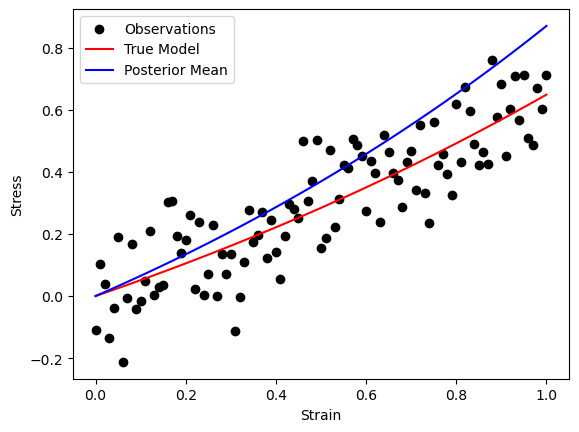

In [6]:
import matplotlib.pyplot as plt

# plot raw data
plt.scatter(data[:,0], data[:,1], label="Observations", color="black")

# draw realistic model
x_true = np.linspace(0, 1, 101)
y_true = neo_hookean_model2(mu_true, alpha_true, x_true)
plt.plot(x_true, y_true, label="True Model", color="red")

# plot the model corresponding to the mean of the posterior distribution
mu_posterior_mean = np.mean(samples[:,0])
alpha_posterior_mean = np.mean(samples[:,1])
y_posterior_mean = neo_hookean_model2(mu_posterior_mean, alpha_posterior_mean, x_true)
plt.plot(x_true, y_posterior_mean, label="Posterior Mean", color="blue")

plt.legend()
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.show()

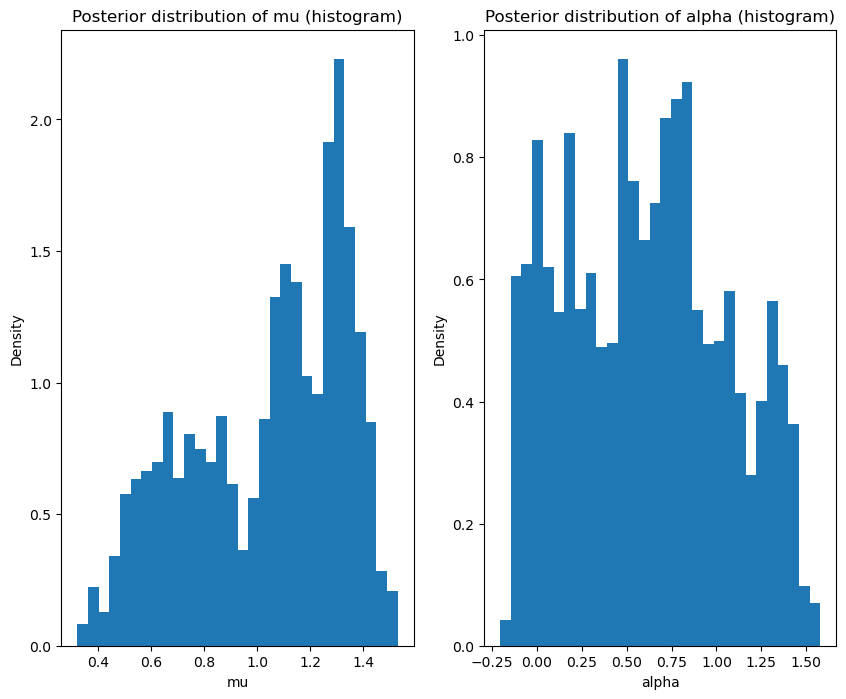

In [7]:
# Plot the histogram of the posterior distribution of mu and alpha
fig, ax = plt.subplots(1,2,figsize=(10, 8))

ax[0].hist(samples[:,0], bins=30, density=True)
ax[0].set_title("Posterior distribution of mu (histogram)")
ax[0].set_xlabel("mu")
ax[0].set_ylabel("Density")

ax[1].hist(samples[:,1], bins=30, density=True)
ax[1].set_title("Posterior distribution of alpha (histogram)")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Density")
plt.show()

参数之间的相关性矩阵和散点图，以了解两个参数之间的相关性。如果两个参数高度相关，则可能需要更多的数据或更复杂的模型来消除相关性。

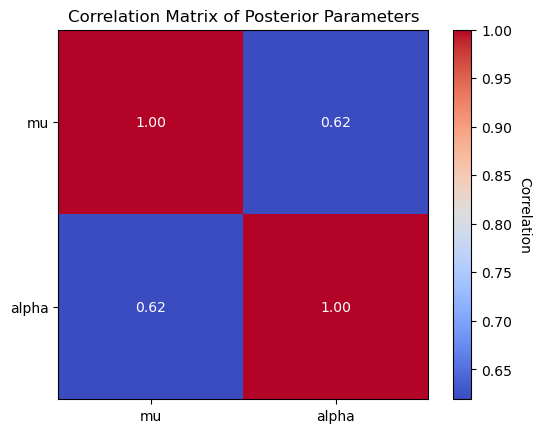

In [8]:
# Calculate the correlation matrix of mu and alpha
corr_matrix = np.corrcoef(samples.T)

# Plot the correlation matrix
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap="coolwarm")

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom")

# xlabel and ylabek
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["mu", "alpha"])
ax.set_yticklabels(["mu", "alpha"])
ax.set_title("Correlation Matrix of Posterior Parameters")

# text on figure
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.2f}".format(corr_matrix[i, j]), ha="center", va="center", color="white")

plt.show()


散点图可以直观地展示两个参数之间的关系，如果两个参数之间存在相关性，则散点图上的点将形成一个线性趋势。热图则可以更清晰地展示两个参数之间的分布情况，如果两个参数之间存在相关性，则在热图上会形成一个斜对角线。在实际应用中，可以使用这些图形来帮助理解参数之间的相关性，并根据需要进行进一步的分析和建模。

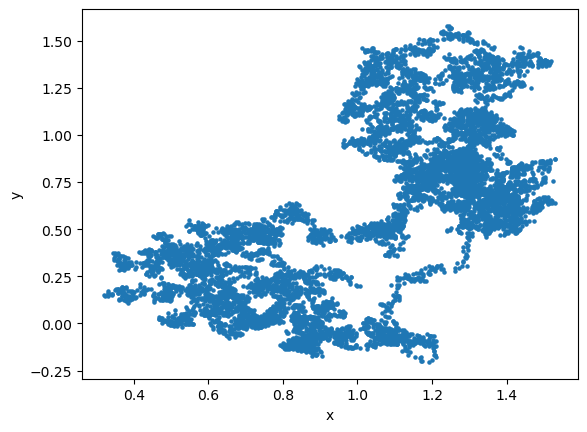

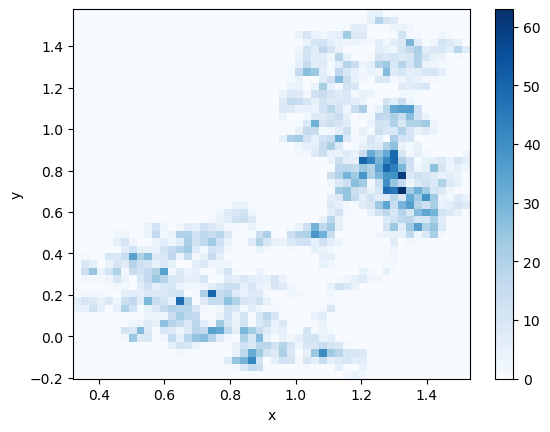

In [9]:
import numpy as np
import matplotlib.pyplot as plt

x = samples[:,0]
y = samples[:,1]

# 绘制散点图
plt.scatter(x, y, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 绘制热图
plt.hist2d(x, y, bins=50, cmap='Blues')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()
